## 1. Dataset Preparation

### 1.1 Data Annotation

In [40]:
import kagglehub
import os
from pathlib import Path
import pandas as pd

os.environ['KAGGLEHUB_CACHE'] = str(Path.cwd() / "data") # Set cache directory to ./data

data_root_dir = kagglehub.dataset_download("tongpython/cat-and-dog")
print("Path to dataset cache:", data_root_dir)
train_cat_dir = Path(data_root_dir) / "training_set" / "training_set" / "cats"
train_dog_dir = Path(data_root_dir) / "training_set" / "training_set" / "dogs"
val_cat_dir = Path(data_root_dir) / "test_set" / "test_set" / "cats"
val_dog_dir = Path(data_root_dir) / "test_set" / "test_set" / "dogs"
# Glob training files
train_cat_files = list(train_cat_dir.glob("**/*.jpg"))
train_dog_files = list(train_dog_dir.glob("**/*.jpg"))
print(f"There are {len(train_cat_files)} cat images, and {len(train_dog_files)} dog images in the training dataset")
df_train = pd.DataFrame({
    'path': list(train_cat_files) + list(train_dog_files),
    'label': ['cat'] * len(list(train_cat_files)) + ['dog'] * len(list(train_dog_files))
})
df_train.to_csv('annotations_train.csv', header=False, index=False)  

# Glob validation files
val_cat_files = list(val_cat_dir.glob("**/*.jpg"))
val_dog_files = list(val_dog_dir.glob("**/*.jpg"))
print(f"There are {len(val_cat_files)} cat images, and {len(val_dog_files)} dog images in the validation dataset")
df_val = pd.DataFrame({
    'path': list(val_cat_files) + list(val_dog_files),
    'label': ['cat'] * len(list(val_cat_files)) + ['dog'] * len(list(val_dog_files))
})
df_val.to_csv('annotations_val.csv', header=False, index=False)  

Path to dataset cache: /home/pbd0/Documents/3321/3321tpl-cat_vs_dog-mlp/data/datasets/tongpython/cat-and-dog/versions/1
There are 4000 cat images, and 4005 dog images in the training dataset
There are 1011 cat images, and 1012 dog images in the validation dataset


### 1.2 PyTorch Dataset Creation


In [46]:
from torchvision.io import decode_image, ImageReadMode
from torchvision.transforms.v2 import Resize
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(3321)

class CatDogDataset(Dataset):
    def __init__(self, annotations_file):
        self.imgs_info = pd.read_csv(annotations_file, header=None)

    def __len__(self):
        return len(self.imgs_info)
    
    def __getitem__(self, idx):
        img_path = self.imgs_info.iloc[idx, 0]
        raw_img = decode_image(img_path, mode=ImageReadMode.RGB)
        img_resize = Resize((64, 64))(raw_img)
        image = img_resize.reshape(1, -1) / 255.  # normalize to [0, 1] and flatten
        category = np.array([1., 0.]) if self.imgs_info.iloc[idx, 1] == 'cat' else np.array([0., 1.])  # one-hot encoding
        # sample = {'image': image.numpy().astype(np.float32), 'category': category.astype(np.float32)}
        sample = {'image': image.squeeze(), 'category': category.squeeze()}

        return sample

### 1.3 Data Pre-Processing


training features batch shape: torch.Size([128, 12288]), a sample features:
 tensor([0.3020, 0.3176, 0.3137,  ..., 0.2314, 0.2745, 0.2667])
training labels batch shape: torch.Size([128, 2]), a sample label: tensor([0., 1.], dtype=torch.float64)
validation features batch shape: torch.Size([128, 12288]), a sample features:
 tensor([0.1882, 0.1529, 0.0902,  ..., 0.0235, 0.0157, 0.0157])
validation labels batch shape: torch.Size([128, 2]), a sample label: tensor([1., 0.], dtype=torch.float64)


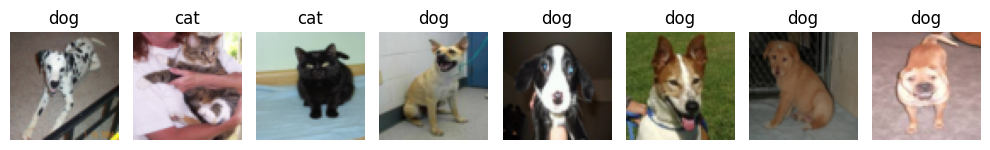

In [47]:
# Extract features/images and targets/labels
dataset_train = CatDogDataset(annotations_file='annotations_train.csv')
dataset_val = CatDogDataset(annotations_file='annotations_val.csv')

# Create data loaders
dataloader_train = DataLoader(dataset_train, batch_size=128, shuffle=True)  # large batch size to get all data in one batch
dataloader_val = DataLoader(dataset_val, batch_size=128, shuffle=False)
# Extract a batch of data from dataloaders
sample_batch_train = next(iter(dataloader_train))
sample_batch_val = next(iter(dataloader_val))

# Probe the data
print(f"training features batch shape: {sample_batch_train['image'].shape}, a sample features:\n {sample_batch_train['image'][0]}")
print(f"training labels batch shape: {sample_batch_train['category'].shape}, a sample label: {sample_batch_train['category'][0]}")
print(f"validation features batch shape: {sample_batch_val['image'].shape}, a sample features:\n {sample_batch_val['image'][0]}")
print(f"validation labels batch shape: {sample_batch_val['category'].shape}, a sample label: {sample_batch_val['category'][0]}")    

# Visualize a few sample images
fig, axs = plt.subplots(1, 8, figsize=(10, 5))
for i in range(8):
    sample_img = np.transpose(sample_batch_train['image'][i].reshape(3, 64, 64), (1, 2, 0))  # reconstruct image to (H, W, C) format
    sample_cls = sample_batch_train['category'][i]
    axs[i] = plt.subplot(1, 8, i + 1)
    axs[i].set_title(f'{"dog" if sample_cls[1] == 1. else "cat"}')
    axs[i].axis('off')
    axs[i].imshow(sample_img)  # image is already in (H, W, C) format
plt.tight_layout()

# Rerun this cell to get different samples.

## 2. Multi-Layer Perceptron Model

A general feature transformation from a previous layer $[l-1]$ to the next layer $[l]$ can be defined as:

$$\mathbf{X}^{[l]} = a(\mathbf{Z}^{[l]}) = a(\mathbf{X}^{[l-1]} \cdot \mathbf{W}^{[l]T} + \mathbf{b}^{[l]}) $$

where $\mathbf{X}^{[l-1]}$ is the input features matrix from layer $[l-1]$. $\mathbf{Z}^{[l]}$ is the linearly transformed $\mathbf{X}^{[l-1]}$ with weight matrix, $\mathbf{W}^{[l]}$ and bias vector, $\mathbf{b}^{[l]}$. $\mathbf{X}^{[l]}$ is the output features matrix for layer $[l]$, which is $\mathbf{Z}^{[l]}$ activated by function $a(\cdot)$. 

## 2.1 Activation Functions

1. Sigmoid

$$\sigma(z) = \frac{1}{1 + e^{-z}} $$
$$\sigma'(x) = \sigma(z) (1 - \sigma(z)) $$

2. Hyper-Tangential

$$\tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}} $$
$$\tanh'(z) = (1 - \tanh^2(z)) $$

3. Rectified Linear Unit (ReLU)
> The modern activation function

$$
ReLU(z) = 
\begin{cases}
    z &\text{if $z > 0$} \\
    0 &\text{otherwise}
\end{cases}
$$

$$
ReLU'(z) = 
\begin{cases}
    1 &\text{if $z > 0$} \\
    0 &\text{otherwise}
\end{cases}
$$

4. Leaky ReLU
> ReLU Pro Max

$$
LR(z) = 
\begin{cases}
    z &\text{if $z > 0$} \\
    az &\text{otherwise ($a$ is a constant)}
\end{cases}
$$

$$
LR'(z) = 
\begin{cases}
    1 &\text{if $z > 0$} \\
    a &\text{otherwise}
\end{cases}
$$

5. For classification problems, softmax activation function are usually applied to the output layer ($[L]$) **only**, to encode the features into probability distributions.

$$
\hat{\mathbf{Y}} = a(\mathbf{Z}^{[L]}) = \frac {e^{Z^{[L]}}} {\sum e^{Z^{[L]}} \text{, axis}=1 \text{, keepdims}=\text{True}}
$$ 

6. For regression problems, no activation will be applied to linear transformed features in the output layer. So, they are also called linear activated output features.


In [52]:
def sigmoid(in_features):
    """ Sigmoid function
    Args:
        in_features: independent variable, could be an arrary of any shape or a scalar. 
    Returns:
        activated_features: dependent variable, could be an arrary of any shape or a scalar. 
    """
    ### START CODE HERE ### (≈ 1 line of code)
    activated_features = 1 / (1 + np.exp(-in_features))
    ### END CODE HERE ###
    return activated_features

def relu(in_features):
    """ ReLU function
    Args:
        in_features: independent variable, could be an arrary of any shape or a scalar. 
    Returns:
        activated_features: dependent variable, could be an arrary of any shape or a scalar. 
    """
    ### START CODE HERE ### (≈ 1 line of code)
    activated_features = np.maximum(0, in_features)
    ### END CODE HERE ###
    return activated_features

def softmax(in_features):
    """ Softmax function
    Args:
        in_features: independent variable, 2d array with shape (# samples, # features)
    Returns:
        activated_features: dependent variable, 2d array with shape (# samples, # features)
    """
    ### START CODE HERE ### (≈ 3 lines of code)
    probability_features = np.exp(in_features) / np.sum(np.exp(in_features), axis=-1, keepdims=True)
    ### END CODE HERE ###
    return probability_features

# Sanity check
x = np.linspace(-2, 2, 10)
print(f"Input = \n{x}")
print(f"Sigmoid activation = {sigmoid(x)}")
print(f"ReLU activation = {relu(x)}")
x_2d = x.reshape(2, 5)
print(f"Input in 2d = \n{x_2d}")
print(f"Softmax activation = {softmax(x_2d)}")



Input = 
[-2.         -1.55555556 -1.11111111 -0.66666667 -0.22222222  0.22222222
  0.66666667  1.11111111  1.55555556  2.        ]
Sigmoid activation = [0.11920292 0.17428532 0.2476638  0.33924363 0.44467194 0.55532806
 0.66075637 0.7523362  0.82571468 0.88079708]
ReLU activation = [0.         0.         0.         0.         0.         0.22222222
 0.66666667 1.11111111 1.55555556 2.        ]
Input in 2d = 
[[-2.         -1.55555556 -1.11111111 -0.66666667 -0.22222222]
 [ 0.22222222  0.66666667  1.11111111  1.55555556  2.        ]]
Softmax activation = [[0.06801606 0.10607944 0.16544399 0.25803034 0.40243017]
 [0.06801606 0.10607944 0.16544399 0.25803034 0.40243017]]


### 2.2. Parameter Initialization


In [57]:
def init_params(in_dim, hidden_layer_dims):

    ### START CODE HERE ### (≈ 4 lines of code)
    params = {}
    layer_dims = [in_dim] + list(hidden_layer_dims)
    for l in range(1, len(layer_dims)):
        params[f'W{l}'] = np.random.normal(loc=0, scale=0.0001, size=(layer_dims[l], layer_dims[l-1]))
        params[f'b{l}'] = np.random.normal(loc=0, scale=0.0001, size=(1, layer_dims[l]))
    ### END CODE HERE ###
    return params



### 2.3 Model Construction
1. Linearly transform features from previous layer: $\mathbf{Z}^{[l]} = \mathbf{X}^{[l-1]} \cdot \mathbf{W}^{[l]T} + \mathbf{b}^{[l]})$.
2. Apply your choice of activation function on $\mathbf{Z}^{[l]}$, so that the features in the next layer will be: $\mathbf{X}^{[l]} = a(\mathbf{Z}^{[l]})$ 
3. Apply your choice of activation function on the last layer $\mathbf{Z}^{[L]}$, so that the model's output will fit the problem's needs: $\hat{\mathbf{Y}} = a(\mathbf{Z}^{[L]})$

In [58]:
def linear(in_features, weights, biases):
    """ Linear function
    Args:
        in_features: input feature matrix, 2d array with shape (# samples, # input features)
        weights: weight parameter matrix, 2d array with shape (# next layer features , # input features)
        biases: bias parameter vector, 2d array with shape (1, # next layer features)
    Returns:
        linear_output: linear model output feature matrix, 2d array with shape (# samples, # next layer features)
    """
    ### START CODE HERE ### (≈ 1 lines of code)
    linear_output = in_features @ weights.T + biases
    ### END CODE HERE ###
    return linear_output

def forward(in_features, params, hidden_activation=None, out_activation=None):
    """ Forward function
    Args:
        in_features: feature matrix, 2d array with shape (# samples, # pixels)
        params: a dictionary of weights and biases
            params = {
                'W_1': weight matrix of the first layer, 2d array with shape (# hidden features in 1st layer, # input features)
                'b_1': bias vector of the first layer, 2d array with shape (1, # hidden features in 1st layer)
                ...
                'W_L': weight matrix of the last layer, 2d array with shape (# hidden features in output layer, # hidden features in L-1 layer)
                'b_L': bias vector of the last layer, 2d array with shape (1, # output features)
            }
        hidden_activation: activation function for hidden layers, could be sigmoid, relu, etc. If None, no activation is applied.
        out_activation: activation function for output layer, could be sigmoid, softmax, etc. If None, no activation is applied.
    Returns:
        predictions: predicted probabilities, a column vector or 2d array with shape (# samples, # output features)
        cache: linear activated features
    """

    ### START CODE HERE ### (≈ 2 lines of code)
    num_layers = len(params) // 2
    cache = {'X0': in_features}
    for layer in range(1, num_layers):
        cache[f'Z{layer}'] = linear(cache[f'X{layer-1}'], params[f'W{layer}'], params[f'b{layer}'])
        if hidden_activation=="relu":
            cache[f'X{layer}'] = relu(cache[f'Z{layer}'])
        elif hidden_activation=="sigmoid":
            cache[f'X{layer}'] = sigmoid(cache[f'Z{layer}'])
        else:
            cache[f'X{layer}'] = cache[f'Z{layer}']
    cache[f'Z{num_layers}'] = linear(cache[f'X{num_layers - 1}'], params[f'W{num_layers}'], params[f'b{num_layers}'])
    if out_activation=="relu":
        predictions = relu(cache[f'Z{num_layers}'])
    elif out_activation=="sigmoid":
        predictions = sigmoid(cache[f'Z{num_layers}'])
    elif out_activation=="softmax":
        predictions = softmax(cache[f'Z{num_layers}'])
    else:
        predictions = cache[f'Z{num_layers}']
    ### END CODE HERE ###
    return predictions, cache

# Sanity check
np.random.seed(3321)  # for reproducibility
params_dummy = init_params(sample_batch_train['image'].shape[-1], (4, 3, 2))
preds_dummy, cache = forward(sample_batch_train['image'], params_dummy, "relu", "softmax")
print(f"Features: {list(cache.keys())[:]}")
print(f"Shape of dummy predictions: {preds_dummy.shape}")
print(f"Dummy prediction samples:\n{preds_dummy[:3]}")
print(f"Samples of dummy predictions: \n{preds_dummy[:3]}")

/tmp/ipykernel_103235/3028292661.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  linear_output = in_features @ weights.T + biases
/tmp/ipykernel_103235/2909177352.py:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  activated_features = np.maximum(0, in_features)
/tmp/ipykernel_103235/2909177352.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  probability_features = np.exp(in_features) / np.sum(np.exp(in_features), axis=-1, keepdims=True)


TypeError: sum() received an invalid combination of arguments - got (keepdims=bool, out=NoneType, axis=int, ), but expected one of:
 * (*, torch.dtype dtype = None)
 * (tuple of ints dim, bool keepdim = False, *, torch.dtype dtype = None)
 * (tuple of names dim, bool keepdim = False, *, torch.dtype dtype = None)
